In [1]:
##要执行的我会在代码段前注释“第i步”
#第一步
import numpy
import pandas as pd
import datetime
import json
import os
import xlrd# 安装xlrd == 1.2.0 版本太高会出错
import numpy as np
import matplotlib.pyplot as plt
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
import copy
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84 as w84
from matplotlib.pyplot import MultipleLocator

### No need to run

In [2]:
def get_allfile(path):  # 获取所有文件
    all_file = []
    for f in os.listdir(path):  #listdir返回文件中所有目录
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file

In [4]:
#第三步
#从TLE中提取相关字段到tle列表中
tle=[]
key_wanted=["NORAD_CAT_ID","OBJECT_NAME","EPOCH","INCLINATION","TLE_LINE1","TLE_LINE2","SEMIMAJOR_AXIS"]
tickets = r"../../Dataset/starlink"
all_file=get_allfile(tickets)  #tickets要获取文件夹名
for i in range(len(all_file)):
    filename=r"%s"%all_file[i]
    #print(filename)
    with open(filename) as f:
        temp=json.load(f)
        for item in temp:
            item["NORAD_CAT_ID"]=int(item["NORAD_CAT_ID"])
            item['SEMIMAJOR_AXIS'] = float(item['SEMIMAJOR_AXIS'])
            item["EPOCH"]=datetime.datetime.strptime('%s.%s'%(item["EPOCH"],item["EPOCH_MICROSECONDS"]),"%Y-%m-%d %H:%M:%S.%f")
            temp2=dict((key,value) for key, value in item.items() if key in key_wanted)
            tle.append(temp2)
df=pd.DataFrame(tle)

#提取到tle后按“NORAD_CAT_ID”分组，并按EPOCH的逆序排序
group = df.groupby("NORAD_CAT_ID")
starlink_dict = {}
for dfGroupBy in group:
    df_dict_key = dfGroupBy[0]
    df_dict_value = pd.DataFrame(dfGroupBy[1])
    starlink_dict[df_dict_key] = df_dict_value.sort_values(by='EPOCH',ascending=False)
#print(starlink_dict['STARLINK-3282'])

In [4]:
maneuver = {}
for i in range(len(starlink_dict.keys())):#len(starlink_dict.keys())
    print(i)
    starlink_maneuver = {}
    starlink_dataframe = starlink_dict[list(starlink_dict.keys())[i]]
    starlink_dataframe = starlink_dataframe[starlink_dataframe['EPOCH'] > datetime.datetime(2022,4,1)]
    if(len(starlink_dataframe) == 0):continue
    axis_1 = float(starlink_dataframe.iloc[0,6])
    axis_2 = float(starlink_dataframe.iloc[len(starlink_dataframe) - 1,6])
    if(abs(axis_1 - axis_2) >= 10):continue
    for j in range(len(starlink_dataframe)):
        axis_sum = 0
        num_sum = 0
        for k in range(5):
            if(j + k >= len(starlink_dataframe)):break
            num_sum = num_sum + 1
            axis_sum = axis_sum + float(starlink_dataframe.iloc[j + k,6])
        for seq in range(5):
            if(j + seq >= len(starlink_dataframe)):break
            new_axis_sum = axis_sum - float(starlink_dataframe.iloc[j + seq,6])
            if(num_sum - 1 == 0):continue
            axis_avg = new_axis_sum / (num_sum - 1)
            if(abs(float(starlink_dataframe.iloc[j + seq,6]) - axis_avg) >= 1):
                if(starlink_dataframe.iloc[j + seq,2] not in starlink_maneuver.keys()):
                    starlink_maneuver[starlink_dataframe.iloc[j + seq,2]] = float(starlink_dataframe.iloc[j + seq,6])
    maneuver[list(starlink_dict.keys())[i]] = starlink_maneuver

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
def exchange_date_str(stime):
    stime_list = stime.split(' ')
    if(stime_list[1] == 'Jan'):
        stime_list[1] = stime_list[1].replace('Jan','-01-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Feb'):
        stime_list[1] = stime_list[1].replace('Feb','-02-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Mar'):
        stime_list[1] = stime_list[1].replace('Mar','-03-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Apr'):
        stime_list[1] = stime_list[1].replace('Apr','-04-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'May'):
        stime_list[1] = stime_list[1].replace('May','-05-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Jun'):
        stime_list[1] = stime_list[1].replace('Jun','-06-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Jul'):
        stime_list[1] = stime_list[1].replace('Jul','-07-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Aug'):
        stime_list[1] = stime_list[1].replace('Aug','-08-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Sep'):
        stime_list[1] = stime_list[1].replace('Sep','-09-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Oct'):
        stime_list[1] = stime_list[1].replace('Oct','-10-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Nov'):
        stime_list[1] = stime_list[1].replace('Nov','-11-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    if(stime_list[1] == 'Dec'):
        stime_list[1] = stime_list[1].replace('Dec','-12-')
        stime = "%s%s%s %s"%(stime_list[0],stime_list[1],stime_list[2],stime_list[3])
    return stime
def exchange_crawler_str(ctime):
    ctime = "%s%s"%(ctime[20:24],ctime[3:19])
    ctime = exchange_date_str(ctime)
    return ctime

In [7]:
#第四步
#这段代码是获取conjunction文件中的数据并存到cunjunction列表中
#先是获取文件夹下所有的文件名
def get_allfile(path):  # 获取所有文件
    all_file = []
    for f in os.listdir(path):  #listdir返回文件中所有目录
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file
    
tickets = r"..\..\Dataset\raw_conjunction_data"
all_file=get_allfile(tickets)  #tickets要获取文件夹名
print(all_file[1])

#再根据文件名提取数据
conjunction = {}
conjunction_dataframe = []
for i in range(len(all_file)):#这里的i就是取出文件夹里的第i+1个文件
    xls_file = xlrd.open_workbook(all_file[i])
    xls_sheet = xls_file.sheets()[0]
    nrows = xls_sheet.nrows
    for j in range(1,nrows):
        row_value = xls_sheet.row_values(j)
        #row_value是想要从conjuction中获取的数据字段，按需增删
        #row_value = [row_value[0],row_value[3],row_value[6],row_value[7],row_value[8],row_value[9],row_value[10],row_value[11],row_value[12]]
        #目前这个row_value提取的字段如下
        #max prob  relative volicity  name1  name2  ID  TCA  start time  stop time  time(crawler)
        if(float(row_value[0]) < 1e-5):continue
        sat_id1 = int(row_value[8].split('-')[0])
        sat_id2 = int(row_value[8].split('-')[1])
        tca = exchange_date_str(row_value[9])
        tca = datetime.datetime.strptime(tca,'%Y-%m-%d %H:%M:%S.%f')
        if(sat_id1 not in conjunction.keys()):
            conjunction[sat_id1] = [tca]
        else:
            conjunction[sat_id1].append(tca)
        if(sat_id2 not in conjunction.keys()):
            conjunction[sat_id2] = [tca]
        else:
            conjunction[sat_id2].append(tca)
        row_value[9] = exchange_date_str(row_value[9])
        row_value[9] = datetime.datetime.strptime(row_value[9],'%Y-%m-%d %H:%M:%S.%f')
        #row_value是想要从conjuction中获取的数据字段，按需增删
        row_value = [float(row_value[0]),float(row_value[3]),row_value[6],row_value[7],sat_id1,sat_id2,row_value[9],row_value[10],row_value[11],row_value[12]]
        #目前这个row_value提取的字段如下
        #max prob  relative volicity  name1  name2  ID  TCA  start time  stop time  time(crawler)
        conjunction_dataframe.append(row_value)

C:\Users\zhaow21\Seafile\debris\data\raw_conjunction_data\conjunction_result_100000_MAXPROB_1650556802.0746994.xls


In [16]:
from datetime import timedelta


result = {}
for key in maneuver.keys():
    if(maneuver[key] == {}):continue
    if(key not in conjunction.keys()):continue
    tca_list = list(maneuver[key].keys())
    for i in range(len(tca_list)):
        for j in range(len(conjunction[key])):
            if(tca_list[i] <= conjunction[key][j]):
                delta_time = conjunction[key][j] - tca_list[i]
                if(timedelta(hours= 11) <= delta_time <= timedelta(hours= 13)):
                    if(key not in result.keys()):
                        result[key] = [conjunction[key][j]]
                    else:
                        result[key].append(conjunction[key][j])

In [9]:
result

{44767: [datetime.datetime(2022, 5, 22, 7, 14, 45, 141000),
  datetime.datetime(2022, 5, 21, 12, 56, 1, 668000),
  datetime.datetime(2022, 5, 21, 0, 57, 11, 701000)],
 44943: [datetime.datetime(2022, 5, 24, 15, 53, 24, 118000),
  datetime.datetime(2022, 5, 24, 15, 53, 24, 118000)],
 44952: [datetime.datetime(2022, 5, 20, 22, 42, 13, 458000),
  datetime.datetime(2022, 5, 20, 22, 42, 13, 458000)],
 45384: [datetime.datetime(2022, 5, 1, 12, 15, 38, 939000),
  datetime.datetime(2022, 5, 1, 10, 40, 2, 755000),
  datetime.datetime(2022, 4, 29, 13, 10, 0, 466000)],
 45391: [datetime.datetime(2022, 5, 21, 20, 22, 3, 143000),
  datetime.datetime(2022, 5, 21, 20, 22, 3, 101000),
  datetime.datetime(2022, 5, 21, 20, 22, 3, 101000)],
 45557: [datetime.datetime(2022, 5, 13, 11, 13, 36, 872000)],
 45568: [datetime.datetime(2022, 5, 16, 9, 9, 46, 246000),
  datetime.datetime(2022, 5, 16, 8, 22, 0, 76000),
  datetime.datetime(2022, 5, 16, 9, 9, 46, 246000),
  datetime.datetime(2022, 5, 16, 8, 22, 0, 7

In [10]:
def ismaneuver(key,start_time,stop_time):
    df = starlink_dict[key]
    df = df[(start_time <= df['EPOCH']) & (df['EPOCH'] <= stop_time)]
    df_axis_list = []
    for i in range(len(df)):
        df_axis_list.append(df.iloc[i,6])
    df_axis_max = max(df_axis_list)
    #print(df_axis_max)
    df_axis_min = min(df_axis_list)
    #print(df_axis_min)
    if((df_axis_max - df_axis_min) < 1):return False
    else:return True

In [13]:
start_end={}
for key in maneuver.keys():
    if(maneuver[key] == {}):continue
    tmp_man=list(sorted(maneuver[key].keys()))
    starlink_df = starlink_dict[key]
    starlink_df = starlink_df[starlink_df['EPOCH'] > datetime.datetime(2022,4,1)]
    #print(np.array(starlink_df["SEMIMAJOR_AXIS"]))
    semi=np.median(np.array(starlink_df["SEMIMAJOR_AXIS"]))
    start=[]
    end=[]
    for i in range(len(tmp_man)):
        item=tmp_man[i]
        tmp_start=starlink_df[starlink_df['EPOCH'] < item]
        tmp_start=tmp_start[abs(tmp_start['SEMIMAJOR_AXIS']-semi)<0.2]
        t=tmp_start['EPOCH'].max()
        if t not in start:
            if len(start)!=0:
                if abs((start[-1]-t).total_seconds())>3600*12:
                    start.append(t)
            else:
                start.append(t)
        
        tmp_end=starlink_df[starlink_df['EPOCH'] > item]
        tmp_end=tmp_end[abs(tmp_end['SEMIMAJOR_AXIS']-semi)<0.2]
        t=tmp_end['EPOCH'].min()
        if t not in end :
            if len(end)!=0:
                if abs((end[-1]-t).total_seconds())>3600*12:
                    end.append(t)
                else:
                    end[-1]=t
            else:
                end.append(t)
    if(key == 48014):
        print(start)
        print(end)
    start = sorted(start)
    end = sorted(end,reverse=True)
    del_list1 = []
    flag1 = 0
    for l1 in range(1,len(start)):
        if((start[l1] - start[flag1]) < datetime.timedelta(days=20)):
            del_list1.append(start[l1])
        else:
            flag1 = l1
    for l1 in range(len(del_list1)):
        start.remove(del_list1[l1])
    del_list2 = []
    flag2 = 0
    for l2 in range(1,len(end)):
        if((end[flag2] - end[l2]) < datetime.timedelta(days=20)):
            del_list2.append(end[l2])
        else:
            flag2 = l2
    for l2 in range(len(del_list2)):
        end.remove(del_list2[l2])
    end.reverse()
    if(key == 48014):
        print(start)
        print(end)
    result = []
    i#f(len(start) != len(end)):
    for x in range(len(start)):
        time_min = datetime.timedelta(days = 999)
        time_ind = 'a'
        for y in range(len(end)):
            if(end[y] <= start[x]):continue
            else:
                if((end[y] - start[x]) < time_min):
                    #print(datetime.datetime.strptime(str(start[x]),"%Y-%m-%d %H:%M:%S.%f"))
                    if(ismaneuver(key,datetime.datetime.strptime(str(start[x]),"%Y-%m-%d %H:%M:%S.%f"),datetime.datetime.strptime(str(end[y]),"%Y-%m-%d %H:%M:%S.%f"))):
                        time_min = end[y] - start[x]
                        time_ind = y
        if(time_ind == 'a'):continue
        result.append([start[x],end[time_ind]])
    # else:
    #     for x in range(len(start)):
    #         result.append([start[x],end[x]])
    start_end[key]=result

[Timestamp('2022-05-04 14:00:01.224000'), Timestamp('2022-06-14 10:58:48.419040')]
[NaT]
[Timestamp('2022-05-04 14:00:01.224000'), Timestamp('2022-06-14 10:58:48.419040')]
[NaT]


In [11]:
maneuver_time = maneuver
for key in maneuver_time.keys():
    if(maneuver_time[key] == []):continue
    maneuver_time[key] = min(maneuver_time[key])

In [14]:
task_maneuver = []
with open(r'.\data\task_maneuver.txt','r') as f:
    for line in f.readlines():
        line = line.strip()
        task_maneuver.append(int(line))
task_maneuver

[45568,
 45579,
 46168,
 46326,
 46334,
 46364,
 46671,
 46712,
 46756,
 46757,
 46770,
 46789,
 47138,
 47139,
 47153,
 47372,
 47384,
 47393,
 47394,
 47399,
 47645,
 47646,
 47660,
 47663,
 47666,
 47722,
 47729,
 47732,
 47735,
 47738,
 47768,
 47805,
 47827,
 47836,
 47901,
 47911,
 47913,
 47980,
 47985,
 47995,
 47998,
 48000,
 48002,
 48014,
 48016,
 48018,
 48020,
 48022,
 48028,
 48092,
 48093,
 48112,
 48125,
 48128,
 48135,
 48292,
 48364,
 48368,
 48395,
 48412,
 48432,
 48433,
 48434,
 48458,
 48459,
 48462,
 48481,
 48484,
 48561,
 48575,
 48578,
 48582,
 48594,
 48640,
 48648,
 48666,
 48681,
 48682,
 48684,
 48686,
 48692]

In [17]:
conj_df = pd.DataFrame(conjunction_dataframe,columns=['pc','relative velocity','name1','name2','sat_id1','sat_id2','TCA','start time','stop time','time(crawler)'])
df = pd.DataFrame(columns=['pc','relative velocity','name1','name2','sat_id1','sat_id2','TCA','start time','stop time','time(crawler)'])
for key in result.keys():
    for i in range(len(result[key])):
        mydf = conj_df[conj_df['sat_id1'] == key][conj_df['TCA'] == result[key][i]]
        df = pd.concat([df,mydf],axis=0,join='outer')
        mydf = conj_df[conj_df['sat_id2'] == key][conj_df['TCA'] == result[key][i]]
        df = pd.concat([df,mydf],axis=0,join='outer')

C:\Users\zhaow21\AppData\Local\Temp\ipykernel_15704\3446396422.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mydf = conj_df[conj_df['sat_id1'] == key][conj_df['TCA'] == result[key][i]]
C:\Users\zhaow21\AppData\Local\Temp\ipykernel_15704\3446396422.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mydf = conj_df[conj_df['sat_id2'] == key][conj_df['TCA'] == result[key][i]]


In [5]:
#第七步
#获取每个tle文件所包含的EPOCH范围
def get_date():
    tle_date = {}
    for i in range(0,150,3):
        filename=r"..\..\Dataset\tle/tle_{}.json".format(i)
        #print(filename)
        with open(filename) as f:
            date = []
            temp=json.load(f)
            for item in temp:
                item["EPOCH"]=datetime.datetime.strptime(item["EPOCH"],"%Y-%m-%d %H:%M:%S")
                date.append(item["EPOCH"])
            date_max = max(date)
            date_min = min(date)
            tle_date[i] = [date_min,date_max]
    return tle_date
tle_date = get_date()

In [6]:
#第八步
#获取TCA时刻 坐标为(x,y,z)的卫星的周围的卫星数量  sat_name1和sat_name2是为了避免将本卫星和将要与本卫星发生conjunction的卫星计入
#当前是计算的100km以内的 可以在本代码段的67行进行设置
def get_density(sat_id1,sat_id2,x1,y1,z1,x2,y2,z2,TCA,tle_date,top_k):
    sat_num = 0 #周围卫星数量
    sat_dis1 = []
    sat_dis2 = []
    obj_name = [] #记录已经被计数的空间物体名称，防止因conjunction数据重复而导致重复计数
    tle_density=[] #存储用来计算密度的tle数据
    #9~25行是取出TCA时刻前最新的所有空间物体的TLE
    #先是获取TCA时刻前最新的TLE对应于tle文件夹下哪个tle文件
    key_wanted=["NORAD_CAT_ID","OBJECT_NAME","EPOCH","INCLINATION","TLE_LINE1","TLE_LINE2","SEMIMAJOR_AXIS"]
    for i in range(0,150,3):
        if(tle_date[i][0] <= TCA <= tle_date[i][1]):
            tle_num = i
            break
    #然后读取该文件
    for j in range(tle_num - 3,tle_num + 1,3):
        if(j >= 0):
            filename=r"..\..\Dataset\tle/tle_{}.json".format(j)
            #print(filename)
            with open(filename) as f:
                temp=json.load(f)
                for item in temp:
                    item["NORAD_CAT_ID"]=int(item["NORAD_CAT_ID"])
                    item["EPOCH"]=datetime.datetime.strptime('%s.%s'%(item["EPOCH"],item["EPOCH_MICROSECONDS"]),"%Y-%m-%d %H:%M:%S.%f")
                    temp2=dict((key,value) for key, value in item.items() if key in key_wanted)
                    tle_density.append(temp2)
    df_density=pd.DataFrame(tle_density)
    
    #提取到tle后按“NORAD_CAT_ID”分组，并按EPOCH的逆序排序
    group_density = df_density.groupby("NORAD_CAT_ID")
    object_dict = {}
    for dfGroupBy in group_density:
        df_dict_key = dfGroupBy[0]
        df_dict_value = pd.DataFrame(dfGroupBy[1])
        object_dict[df_dict_key] = df_dict_value.sort_values(by='EPOCH',ascending=False)
    #37~71行是根据tle文件计算周围卫星数量
    for key in object_dict.keys():
        object_dataframe = object_dict[key]
        if(key in obj_name):
            continue
        else:
            obj_name.append(key)
        #print('object name is ',object_name)
        #print('name1 is ',sat_name1)
        #print('name2 is ',sat_name2)
        if(key == sat_id1):continue
        if(key == sat_id2):continue
        tle_line1_3 = []
        tle_line2_3 = []
        for loc_num3 in range(len(object_dataframe)):
            time3 = object_dataframe.iloc[loc_num3,2]
            if(TCA - datetime.timedelta(days=2) <= time3 <= TCA):
                tle_line1_3.append(object_dataframe.iloc[loc_num3,4])
                tle_line2_3.append(object_dataframe.iloc[loc_num3,5])
        if(tle_line1_3 == [] or tle_line2_3 == []):
            continue
        line1_3 = tle_line1_3[0]
        line2_3 = tle_line2_3[0]
        year = TCA.year
        month = TCA.month
        day = TCA.day
        hour = TCA.hour
        minute = TCA.minute
        second = TCA.second
        ts = load.timescale()
        sat3 = EarthSatellite(line1_3,line2_3,"STARLINK",ts)
        t = ts.utc(year,month,day,hour,minute,second)
        geocentric3 = sat3.at(t)
        position3 = geocentric3.position.km
        # #根据sgp4来计算两个卫星在TCA时刻的位置和速度
        # satellite3 = twoline2rv(line1_3, line2_3, wgs84)
        # position3, _ = satellite3.propagate(year, month, day, hour, minute, second)
        dis1 = numpy.sqrt(numpy.square(x1 - position3[0]) + numpy.square(y1 - position3[1]) + numpy.square(z1 - position3[2]))
        dis2 = numpy.sqrt(numpy.square(x2 - position3[0]) + numpy.square(y2 - position3[1]) + numpy.square(z2 - position3[2]))
        sat_dis1.append(dis1)
        sat_dis2.append(dis2)
    sat_dis1 = sorted(sat_dis1)
    dis_sum1 = 0
    dis_num1 = 0
    for x in range(10):
        if(x >= len(sat_dis1)):break
        dis_sum1 = dis_sum1 + sat_dis1[x]
        dis_num1 = dis_num1 + 1
    dis_avg1 = dis_sum1 / dis_num1
    sat_dis2 = sorted(sat_dis2)
    dis_sum2 = 0
    dis_num2 = 0
    for x in range(top_k):
        if(x >= len(sat_dis2)):break
        dis_sum2 = dis_sum2 + sat_dis2[x]
        dis_num2 = dis_num2 + 1
    dis_avg2 = dis_sum2 / dis_num2
    return dis_avg1,dis_avg2,sat_dis1,sat_dis2

In [ ]:
starlink_dict[48583]

In [45]:
top_k_list = [1,3,5,7,10]
num1_list = []
num2_list = []
for seq in range(len(top_k_list)):
    num1 = 0
    num2 = 0
    id_list = []
    for key in result.keys():
        if(result[key] == {}):continue
        if(key in task_maneuver):continue
        plt_df1 = df[df['sat_id1'] == key]
        plt_df2 = df[df['sat_id2'] == key]
        plt_df = pd.concat([plt_df1,plt_df2],axis=0,join='outer')
        #print(plt_df)
        drop_list = []
        for ll in range(len(plt_df)):
            if(plt_df.iloc[ll,6] not in result[key]):
                drop_list.append(list(plt_df.index)[ll])
        plt_df = plt_df.drop(drop_list,axis=0)
        plt_df = plt_df.drop_duplicates(subset=['sat_id1','sat_id2','TCA'])
        for i in range(len(plt_df)):
            tca_df = plt_df[plt_df['TCA'] == result[key][i]]
            if(plt_df.iloc[i,4] == key):
                sat_id1 = plt_df.iloc[i,4]
                sat_id2 = plt_df.iloc[i,5]
            else:
                sat_id1 = plt_df.iloc[i,5]
                sat_id2 = plt_df.iloc[i,4]
            #print('sat_id1 is ',sat_id1,'sat_id2 is ',sat_id2)
            sat_name1 = plt_df.iloc[i,2]
            sat_name2 = plt_df.iloc[i,3]
            #print(sat_id1,sat_id2)
            if((sat_name1.startswith('STARLINK') == False) or (sat_name2.startswith('STARLINK') == False)):continue
            #if('%s-%s'%(sat_id1,sat_id2) in id_list):continue
            #id_list.append('%s-%s'%(sat_id1,sat_id2))
            dataframe1 = starlink_dict[sat_id1]
            dataframe2 = starlink_dict[sat_id2]
            tca_time = tca_df.iloc[0,6]
            print('tca is ',tca_time)
            mtime = 0
            for list_num in range(len(start_end[sat_id1])):
                if(abs((start_end[sat_id1][list_num][0] - tca_time).total_seconds()) > 5*24*60*60):continue
                else:mtime = start_end[sat_id1][list_num][0]
            print('mtime is ',mtime)
            if(mtime == 0):continue
            tle1_1 = []
            tle1_2 = []
            tle_time1 = []
            tle2_1 = []
            tle2_2 = []
            tle_time2 = []
            for loc_num1 in range(len(dataframe1)):
                time1 = dataframe1.iloc[loc_num1,2]
                if(mtime - datetime.timedelta(days=7) <= time1 <= mtime):
                    tle1_1.append(dataframe1.iloc[loc_num1,4])
                    tle1_2.append(dataframe1.iloc[loc_num1,5])
                    tle_time1.append(dataframe1.iloc[loc_num1,2])
            for loc_num2 in range(len(dataframe2)):
                time2 = dataframe2.iloc[loc_num2,2]
                if(mtime - datetime.timedelta(days=7) <= time2 <= mtime):
                    tle2_1.append(dataframe2.iloc[loc_num2,4])
                    tle2_2.append(dataframe2.iloc[loc_num2,5])
                    tle_time2.append(dataframe2.iloc[loc_num2,2])
            line1_1 = tle1_1[0]
            line1_2 = tle1_2[0]
            line2_1 = tle2_1[0]
            line2_2 = tle2_2[0]

            myear = mtime.year
            mmonth = mtime.month
            mday = mtime.day
            mhour = mtime.hour
            mminute = mtime.minute
            msecond = mtime.second
            
            ts = load.timescale()
            sat = EarthSatellite(line1_1,line1_2,None,ts)
            t = ts.utc(myear,mmonth,mday,mhour,mminute,msecond)
            geocentric1 = sat.at(t)
            mposition1 = geocentric1.position.km
            #print('position1 is',mposition1)
            
            sat = EarthSatellite(line2_1,line2_2,None,ts)
            t = ts.utc(myear,mmonth,mday,mhour,mminute,msecond)
            geocentric2 = sat.at(t)
            mposition2 = geocentric2.position.km
            #print('position2 is ',mposition2)
            print(sat_id1,sat_id2,mposition1[0],mposition1[1],mposition1[2],mposition2[0],mposition2[1],mposition2[2],mtime)
            avg1,avg2 = get_density(sat_id1,sat_id2,mposition1[0],mposition1[1],mposition1[2],mposition2[0],mposition2[1],mposition2[2],mtime,tle_date,top_k_list[seq])
            print('avg is ',avg1,avg2)
            if(avg1 >= avg2):num1 = num1 + 1
            else:num2 = num2 + 1
            print('num is ',num1,num2)
    num1_list.append(num1)
    num2_list.append(num2)
    print('top k is ',top_k_list[seq])
    print(num1_list)
    print(num2_list)

tca is  2022-05-22 07:14:45.141000
mtime is  2022-05-19 21:35:09.975264
44767 48445 6698.685702830303 -1757.4810168554418 -20.264226862817967 4765.307604134625 -4330.179277808225 2540.5573982421747 2022-05-19 21:35:09.975264
avg is  399.0354809749724 178.6419931533913
num is  1 0
tca is  2022-05-21 12:56:01.668000
mtime is  2022-05-19 21:35:09.975264
44767 48445 6698.685702830303 -1757.4810168554418 -20.264226862817967 4765.307604134625 -4330.179277808225 2540.5573982421747 2022-05-19 21:35:09.975264
avg is  399.0354809749724 178.6419931533913
num is  2 0
tca is  2022-05-21 00:57:11.701000
mtime is  2022-05-19 21:35:09.975264
44767 46564 6698.685702830303 -1757.4810168554418 -20.264226862817967 3391.9304940712404 -4601.602206128417 3899.965946725432 2022-05-19 21:35:09.975264
avg is  399.0354809749724 69.10955914346395
num is  3 0
tca is  2022-05-24 15:53:24.118000
mtime is  0
tca is  2022-05-20 22:42:13.458000
mtime is  2022-05-19 21:43:07.128768
44952 48002 565.5948067075834 6901.829

In [7]:
_,_,sat_dis1,sat_dis2 = get_density(48117,45235,6728.42626520315,1642.7066330436694,-18.1472990012397,4040.2996980592916,-1576.0075940449556,5389.096696343373,datetime.datetime.strptime('2022-04-26 20:49:00.610752',"%Y-%m-%d %H:%M:%S.%f"),tle_date,7)

In [34]:
np.average(sat_dis2[:7])

193.12097180492628

### Start from this line

<Figure size 432x288 with 0 Axes>

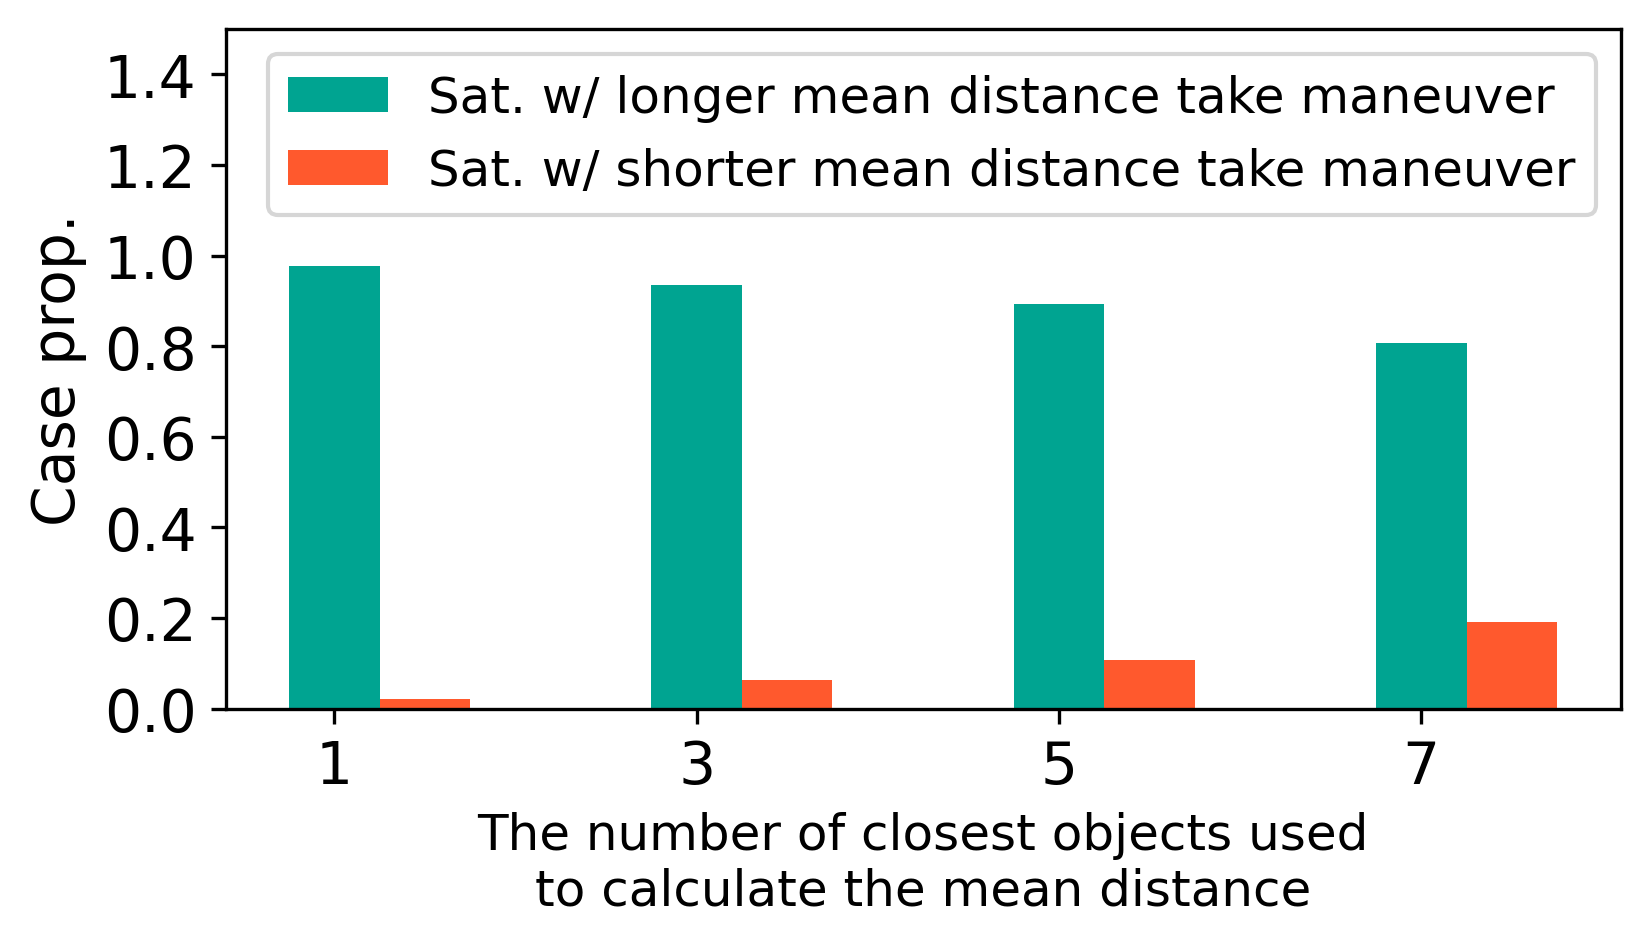

In [5]:
bar_list1 = [0.978, 0.936, 0.893, 0.808]
bar_list2 = [0.022, 0.064, 0.107, 0.192]
sub = [1,3,5,7]
sub2 = [1.5,3.5,5.5,7.5]
bar_width = 0.5
plt.figure(1)
plt.figure(figsize=(6,3),dpi = 300)
plt.bar(sub,bar_list1,label = 'Maneuver sat. with bigger avg.',color = "#00A491",width=bar_width)
plt.bar(sub2,bar_list2,label = 'Maneuver sat. with smaller avg.',color = "#FF592D",width=bar_width)
plt.legend(['Sat. w/ longer mean distance take maneuver','Sat. w/ shorter mean distance take maneuver'],fontsize = 12)
plt.xlabel('The number of closest objects used\nto calculate the mean distance',fontsize = 12)
plt.ylabel('Case prop.',fontsize = 14)
plt.xticks([1,3,5,7],fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim([0,1.5])
plt.savefig(r'figure22b.pdf',bbox_inches='tight')

In [8]:
starlink_dict[48117].iloc[0]

EPOCH                                    2022-07-19 11:07:28.132320
INCLINATION                                                 53.0552
NORAD_CAT_ID                                                  48117
OBJECT_NAME                                           STARLINK-2455
SEMIMAJOR_AXIS                                              6925.33
TLE_LINE1         1 48117U 21027AB  22200.46352005  .00001898  0...
TLE_LINE2         2 48117  53.0552 358.7494 0001236  94.8815 265...
Name: 3199474, dtype: object

In [13]:
for key in starlink_dict.keys():
    if((key != 48117) and (key != 45235)):continue#46326 47913
    starlink_dict[key]['alltitude'] = ''
    for i in range(len(starlink_dict[key])):#len(starlink_dict[key])
        tle_line1 = starlink_dict[key]['TLE_LINE1'].iloc[i]
        tle_line2 = starlink_dict[key]['TLE_LINE2'].iloc[i]
        #starlink_dict[key]['EPOCH'].iloc[i] = datetime.datetime.strptime(starlink_dict[key]['EPOCH'].iloc[i],"%Y-%m-%d %H:%M:%S")
        tle_epoch = starlink_dict[key]['EPOCH'].iloc[i]
        year = tle_epoch.year
        month = tle_epoch.month
        day = tle_epoch.day
        hour = tle_epoch.hour
        minute = tle_epoch.minute
        second = tle_epoch.second

        ts = load.timescale()
        sat = EarthSatellite(tle_line1,tle_line2,None,ts)
        t = ts.utc(year,month,day,hour,minute,second)
        geocentric = sat.at(t)
        h = w84.height_of(geocentric).km
        starlink_dict[key]['alltitude'].iloc[i] = h

/root/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
starlink_dict_new = {}
for item in [48117,45235]:
    starlink_dict_new[item] = starlink_dict[item]

In [18]:
np.save('starlink_dict.npy',starlink_dict_new)

In [2]:
starlink_dict = np.load('./data/starlink_dict.npy',allow_pickle=True).item()

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

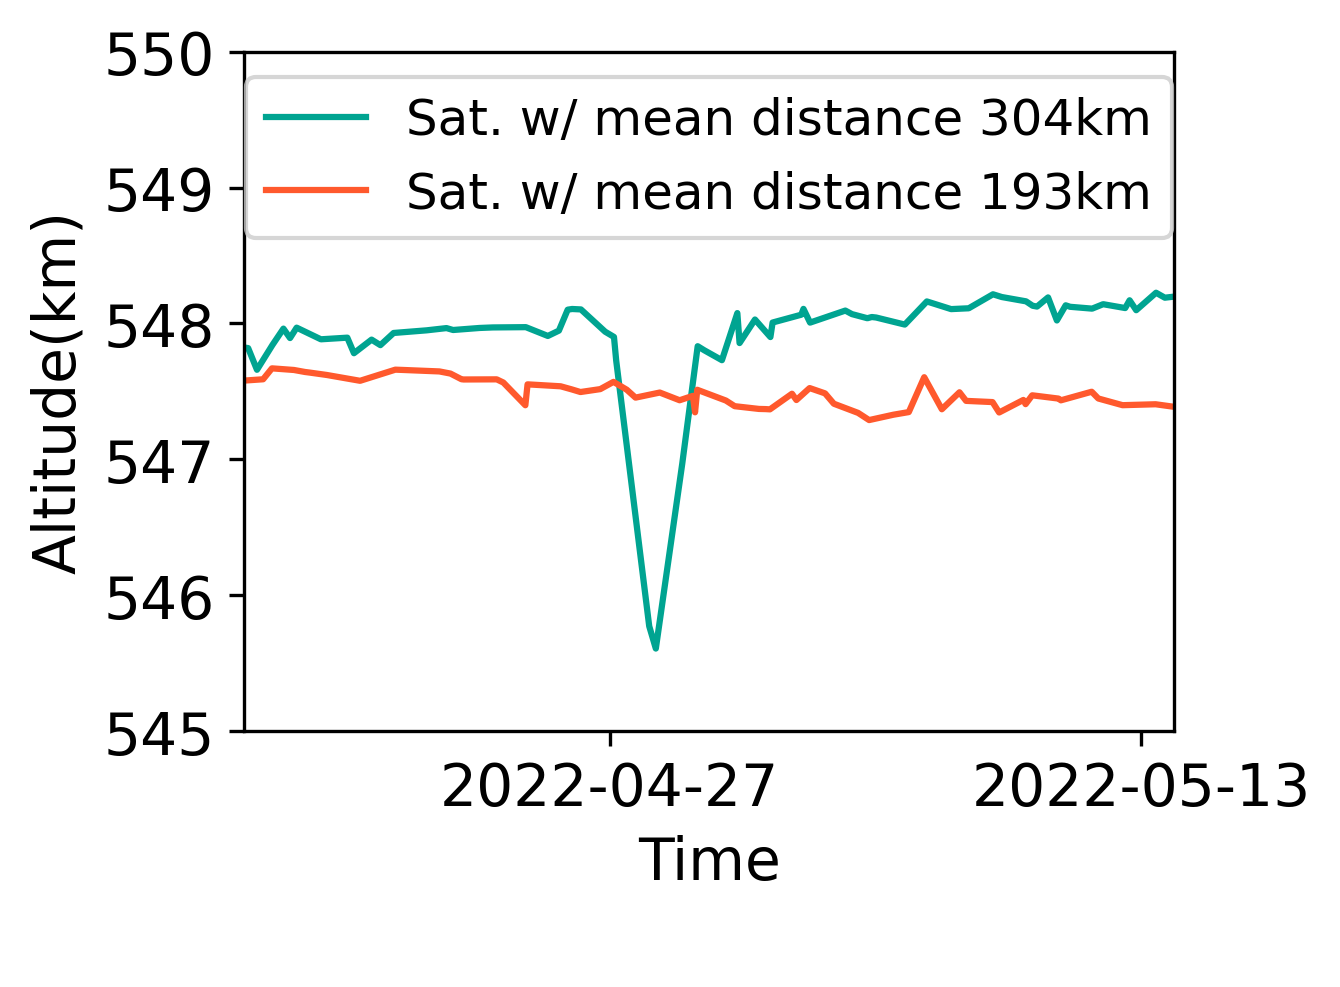

In [3]:
sat_df1 = starlink_dict[48117]
sat_df1 = sat_df1[(sat_df1['EPOCH'] >= datetime.datetime(2022,4,15)) & (sat_df1['EPOCH'] <= datetime.datetime(2022,5,15))]
sat_df2 = starlink_dict[45235]
sat_df2 = sat_df2[(sat_df2['EPOCH'] >= datetime.datetime(2022,4,15)) & (sat_df2['EPOCH'] <= datetime.datetime(2022,5,15))]
x_major_locator=MultipleLocator(16)
plt.figure(1)
fig = plt.figure(figsize=(4,3),dpi=300)
axes = fig.subplots(1,1,sharex=True)
# plt.subplot(211)
# plt.plot(list(sat_df1['EPOCH']),list(sat_df1['SEMIMAJOR_AXIS']),color = "#00A491")
# plt.plot(list(sat_df2['EPOCH']),list(sat_df2['SEMIMAJOR_AXIS']),color = "#FF592D")
# plt.legend(['Starlink-48117(with average distance 304km)','Starlink-45235(with average distance 193km)'],fontsize=8)
# plt.ylabel('Semi-axis(km)',fontsize = 12)
# plt.ylim([6922,6930])
# axes[0].xaxis.set_major_locator(x_major_locator)
# plt.subplot(212)
plt.plot(list(sat_df1['EPOCH']),list(sat_df1['alltitude']),color = "#00A491")
plt.plot(list(sat_df2['EPOCH']),list(sat_df2['alltitude']),color = "#FF592D")
plt.ylabel('Altitude(km)',fontsize=14)
plt.legend(['Sat. w/ mean distance 304km','Sat. w/ mean distance 193km'],fontsize=12,loc=9)
plt.ylim([545,550])
plt.xlabel('Time\n',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlim([datetime.datetime(2022,4,16),datetime.datetime(2022,5,14)])
axes.xaxis.set_major_locator(x_major_locator)
plt.savefig(r'figure22a.pdf',bbox_inches='tight')